<a href="https://colab.research.google.com/github/Adil1979/P6_Tag_Recommendation_Stackoverflow/blob/master/01_P6_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Projet6: Catégorisation automatique de questions**

## **1.Librairies**

In [2]:
!pip install feature_engine

In [3]:
!pip install plotly

In [4]:
!pip install chart-studio

In [5]:
!pip install gensim # Gensim is an open-source library for unsupervised topic modeling and natural language processing

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.lines import Line2D
import matplotlib as mpl
import chart_studio.plotly.plotly as py
from collections import Counter
#import plotly.plotly as py
import seaborn as sns
import datetime as dt
import calendar as cld
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import scale
from os import listdir
import glob
import missingno as msno
from feature_engine.categorical_encoders import OneHotCategoricalEncoder
from sklearn.decomposition import PCA
from matplotlib import dates
import nltk
import re
from nltk.corpus import stopwords 
nltk.download('stopwords')
from nltk.stem.porter import PorterStemmer 
import string
from collections import Counter
from bs4 import BeautifulSoup
import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


SELECT Id, Body, Title, Tags

FROM Posts

WHERE Score >= 3 AND PostTypeId = 1

ORDER BY RAND()
 
ASC OFFSET 0 ROWS FETCH NEXT 50000 ROWS ONLY; de 0 à 50000

## **2.Data**

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [8]:
'''df_analysis_01 = pd.read_csv('/content/drive/My Drive/CentraleSupelec_OCR/P6/QueryResults_01.csv')
df_analysis_02 = pd.read_csv('/content/drive/My Drive/CentraleSupelec_OCR/P6/QueryResults_02.csv')
df_analysis_03 = pd.read_csv('/content/drive/My Drive/CentraleSupelec_OCR/P6/QueryResults_03.csv')
frames = [df_analysis_01, df_analysis_02, df_analysis_03]
df_analysis = pd.concat(frames)
df_sample = df_analysis.sample(n=40000)
df_sample.to_csv('df_sample.csv')'''

"df_analysis_01 = pd.read_csv('/content/drive/My Drive/CentraleSupelec_OCR/P6/QueryResults_01.csv')\ndf_analysis_02 = pd.read_csv('/content/drive/My Drive/CentraleSupelec_OCR/P6/QueryResults_02.csv')\ndf_analysis_03 = pd.read_csv('/content/drive/My Drive/CentraleSupelec_OCR/P6/QueryResults_03.csv')\nframes = [df_analysis_01, df_analysis_02, df_analysis_03]\ndf_analysis = pd.concat(frames)\ndf_sample = df_analysis.sample(n=40000)\ndf_sample.to_csv('df_sample.csv')"

In [9]:
df_sample = pd.read_csv('/content/drive/My Drive/CentraleSupelec_OCR/P6/df_sample.csv')
df_sample.head()

,Id,Title,Body,Tags
0,59320559,Application Insights add username to telemetry,<p>I'm trying to log the usernames for users i...,<c#><asp.net><azure-application-insights>
1,59869126,Fill with the values from neighbor value compe...,<p>I am having dataframe like this:</p>\n\n<pr...,<python><pandas><dataframe>
2,56041778,Specify a secret in YML WITH a namespace,<p>The example has:</p>\n\n<pre><code>apiVersi...,<kubernetes><kubectl>
3,64525292,FunSet Elm- fold operation,<p>I am trying to solve this question.</p>\n<p...,<elm><fold>
4,60678543,Is there always the same execution sequence fo...,<p>Lets assume a simple If Statement with two ...,<c++><if-statement><multiple-conditions>


In [10]:
df_sample.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Id      40000 non-null  int64 
 1   Title   40000 non-null  object
 2   Body    40000 non-null  object
 3   Tags    40000 non-null  object
dtypes: int64(1), object(3)
memory usage: 1.2+ MB


In [11]:
df_sample = df_sample.loc[:, ['Id', 'Title', 'Body', 'Tags']]
df_sample = df_sample.set_index('Id').reset_index(drop=True)
df_sample.head()

,Title,Body,Tags
0,Application Insights add username to telemetry,<p>I'm trying to log the usernames for users i...,<c#><asp.net><azure-application-insights>
1,Fill with the values from neighbor value compe...,<p>I am having dataframe like this:</p>\n\n<pr...,<python><pandas><dataframe>
2,Specify a secret in YML WITH a namespace,<p>The example has:</p>\n\n<pre><code>apiVersi...,<kubernetes><kubectl>
3,FunSet Elm- fold operation,<p>I am trying to solve this question.</p>\n<p...,<elm><fold>
4,Is there always the same execution sequence fo...,<p>Lets assume a simple If Statement with two ...,<c++><if-statement><multiple-conditions>


## **3.Preprocessing**

In [12]:
df_sample.duplicated(subset=["Body", "Title"]).sum()

0

In [13]:
example_body = df_sample.Body.iloc[0]

In [14]:
example_body

"<p>I'm trying to log the usernames for users in application insights when they are doing requests.</p>\n\n<p>I've been trying to do it this way as:</p>\n\n<pre><code> public class AppInsightsInitializer : ClientIpHeaderTelemetryInitializer\n    {\n        private readonly IHttpContextAccessor _httpContextAccessor;\n\n        public AppInsightsInitializer(IHttpContextAccessor httpContextAccessor) : base(httpContextAccessor)\n        {\n            _httpContextAccessor = httpContextAccessor;\n        }\n\n        protected override void OnInitializeTelemetry(HttpContext platformContext, RequestTelemetry requestTelemetry, ITelemetry telemetry)\n        {\n            var userName = _httpContextAccessor.HttpContext?.User?.Identity?.Name; // Only set when request failed...\n            var ip = _httpContextAccessor.HttpContext?.Connection?.RemoteIpAddress?.ToString();\n            if (userName != null) requestTelemetry.Context.User.AuthenticatedUserId= userName;\n        }\n    }\n</code><

In [15]:
example_title = df_sample.Title.iloc[0]

In [16]:
example_title

'Application Insights add username to telemetry'

In [17]:
#Merge Title and Body
df_sample['Title_Body'] = df_sample['Title'] + ' ' + df_sample['Body']

In [18]:
df_sample.head()


,Title,Body,Tags,Title_Body
0,Application Insights add username to telemetry,<p>I'm trying to log the usernames for users i...,<c#><asp.net><azure-application-insights>,Application Insights add username to telemetry...
1,Fill with the values from neighbor value compe...,<p>I am having dataframe like this:</p>\n\n<pr...,<python><pandas><dataframe>,Fill with the values from neighbor value compe...
2,Specify a secret in YML WITH a namespace,<p>The example has:</p>\n\n<pre><code>apiVersi...,<kubernetes><kubectl>,Specify a secret in YML WITH a namespace <p>Th...
3,FunSet Elm- fold operation,<p>I am trying to solve this question.</p>\n<p...,<elm><fold>,FunSet Elm- fold operation <p>I am trying to s...
4,Is there always the same execution sequence fo...,<p>Lets assume a simple If Statement with two ...,<c++><if-statement><multiple-conditions>,Is there always the same execution sequence fo...


In [19]:
variables_reorganization = ['Title_Body', 'Tags']
df_sample = df_sample[['Title_Body', 'Tags']]

In [20]:
df_sample.head()

,Title_Body,Tags
0,Application Insights add username to telemetry...,<c#><asp.net><azure-application-insights>
1,Fill with the values from neighbor value compe...,<python><pandas><dataframe>
2,Specify a secret in YML WITH a namespace <p>Th...,<kubernetes><kubectl>
3,FunSet Elm- fold operation <p>I am trying to s...,<elm><fold>
4,Is there always the same execution sequence fo...,<c++><if-statement><multiple-conditions>


In [21]:
df_sample.Title_Body.iloc[0]

"Application Insights add username to telemetry <p>I'm trying to log the usernames for users in application insights when they are doing requests.</p>\n\n<p>I've been trying to do it this way as:</p>\n\n<pre><code> public class AppInsightsInitializer : ClientIpHeaderTelemetryInitializer\n    {\n        private readonly IHttpContextAccessor _httpContextAccessor;\n\n        public AppInsightsInitializer(IHttpContextAccessor httpContextAccessor) : base(httpContextAccessor)\n        {\n            _httpContextAccessor = httpContextAccessor;\n        }\n\n        protected override void OnInitializeTelemetry(HttpContext platformContext, RequestTelemetry requestTelemetry, ITelemetry telemetry)\n        {\n            var userName = _httpContextAccessor.HttpContext?.User?.Identity?.Name; // Only set when request failed...\n            var ip = _httpContextAccessor.HttpContext?.Connection?.RemoteIpAddress?.ToString();\n            if (userName != null) requestTelemetry.Context.User.Authenticat

### **HTML**

In [22]:
#HTML characters removing
def remove_html(body):
  html_regex = re.compile('<.*?>') #Compile regular expresions
  return re.sub(html_regex, ' ', str(body)) # Replace regex by ' '

In [23]:
df_sample['Title_Body'] = df_sample['Title_Body'].apply(remove_html)
df_sample.head()

,Title_Body,Tags
0,Application Insights add username to telemetry...,<c#><asp.net><azure-application-insights>
1,Fill with the values from neighbor value compe...,<python><pandas><dataframe>
2,Specify a secret in YML WITH a namespace The ...,<kubernetes><kubectl>
3,FunSet Elm- fold operation I am trying to sol...,<elm><fold>
4,Is there always the same execution sequence fo...,<c++><if-statement><multiple-conditions>


In [24]:
df_sample.Title_Body.iloc[0]

"Application Insights add username to telemetry  I'm trying to log the usernames for users in application insights when they are doing requests. \n\n I've been trying to do it this way as: \n\n   public class AppInsightsInitializer : ClientIpHeaderTelemetryInitializer\n    {\n        private readonly IHttpContextAccessor _httpContextAccessor;\n\n        public AppInsightsInitializer(IHttpContextAccessor httpContextAccessor) : base(httpContextAccessor)\n        {\n            _httpContextAccessor = httpContextAccessor;\n        }\n\n        protected override void OnInitializeTelemetry(HttpContext platformContext, RequestTelemetry requestTelemetry, ITelemetry telemetry)\n        {\n            var userName = _httpContextAccessor.HttpContext?.User?.Identity?.Name; // Only set when request failed...\n            var ip = _httpContextAccessor.HttpContext?.Connection?.RemoteIpAddress?.ToString();\n            if (userName != null) requestTelemetry.Context.User.AuthenticatedUserId= userName;

### **URL**

In [25]:
#URL removing
def remove_url(body):
  url_regex = 'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+'
  return re.sub(url_regex, ' ', str(body))  

In [26]:
df_sample['Title_Body'] = df_sample['Title_Body'].apply(remove_url)
df_sample.head()

,Title_Body,Tags
0,Application Insights add username to telemetry...,<c#><asp.net><azure-application-insights>
1,Fill with the values from neighbor value compe...,<python><pandas><dataframe>
2,Specify a secret in YML WITH a namespace The ...,<kubernetes><kubectl>
3,FunSet Elm- fold operation I am trying to sol...,<elm><fold>
4,Is there always the same execution sequence fo...,<c++><if-statement><multiple-conditions>


In [27]:
df_sample.Title_Body.iloc[0]

"Application Insights add username to telemetry  I'm trying to log the usernames for users in application insights when they are doing requests. \n\n I've been trying to do it this way as: \n\n   public class AppInsightsInitializer : ClientIpHeaderTelemetryInitializer\n    {\n        private readonly IHttpContextAccessor _httpContextAccessor;\n\n        public AppInsightsInitializer(IHttpContextAccessor httpContextAccessor) : base(httpContextAccessor)\n        {\n            _httpContextAccessor = httpContextAccessor;\n        }\n\n        protected override void OnInitializeTelemetry(HttpContext platformContext, RequestTelemetry requestTelemetry, ITelemetry telemetry)\n        {\n            var userName = _httpContextAccessor.HttpContext?.User?.Identity?.Name; // Only set when request failed...\n            var ip = _httpContextAccessor.HttpContext?.Connection?.RemoteIpAddress?.ToString();\n            if (userName != null) requestTelemetry.Context.User.AuthenticatedUserId= userName;

### **Punctuation**

In [28]:
#Punctuation removing
def remove_punc(body):
  clean_text = re.sub(r'[?|!|"|:|=|_|{|}|[|]|-|$|%|^|&|]',r' ',str(body))
  clean_text = re.sub(r'[.|,|)|(|\|/|-|~|`|>|<|*|$|@|;|→]',r' ', clean_text)
  return clean_text

In [29]:
df_sample['Title_Body'] = df_sample['Title_Body'].apply(remove_punc)

In [30]:
df_sample.Title_Body.iloc[0]

" Application Insights add username to telemetry  I'm trying to log the usernames for users in application insights when they are doing requests  \n\n I've been trying to do it this way as  \n\n   public class AppInsightsInitializer   ClientIpHeaderTelemetryInitializer\n     \n        private readonly IHttpContextAccessor  httpContextAccessor \n\n        public AppInsightsInitializer IHttpContextAccessor httpContextAccessor    base httpContextAccessor \n         \n             httpContextAccessor   httpContextAccessor \n         \n\n        protected override void OnInitializeTelemetry HttpContext platformContext  RequestTelemetry requestTelemetry  ITelemetry telemetry \n         \n            var userName    httpContextAccessor HttpContext  User  Identity  Name     Only set when request failed   \n            var ip    httpContextAccessor HttpContext  Connection  RemoteIpAddress  ToString   \n            if  userName    null  requestTelemetry Context User AuthenticatedUserId  userName

### **Other characters**

In [31]:
#All characters removing except letters, numbers 
#Lower
def remove_other(body):
  text = str(body)
  clean_text = re.sub(r"[^a-zA-Z0-9#+-]", " ", text.lower())
  return clean_text

In [32]:
df_sample['Title_Body'] = df_sample['Title_Body'].apply(remove_other)
df_sample.head()

,Title_Body,Tags
0,application insights add username to telemetr...,<c#><asp.net><azure-application-insights>
1,fill with the values from neighbor value comp...,<python><pandas><dataframe>
2,specify a secret in yml with a namespace the...,<kubernetes><kubectl>
3,funset elm fold operation i am trying to so...,<elm><fold>
4,is there always the same execution sequence f...,<c++><if-statement><multiple-conditions>


In [33]:
df_sample.Title_Body.iloc[0]

' application insights add username to telemetry  i m trying to log the usernames for users in application insights when they are doing requests     i ve been trying to do it this way as       public class appinsightsinitializer   clientipheadertelemetryinitializer               private readonly ihttpcontextaccessor  httpcontextaccessor           public appinsightsinitializer ihttpcontextaccessor httpcontextaccessor    base httpcontextaccessor                         httpcontextaccessor   httpcontextaccessor                     protected override void oninitializetelemetry httpcontext platformcontext  requesttelemetry requesttelemetry  itelemetry telemetry                        var username    httpcontextaccessor httpcontext  user  identity  name     only set when request failed                var ip    httpcontextaccessor httpcontext  connection  remoteipaddress  tostring                if  username    null  requesttelemetry context user authenticateduserid  username                 

### **Space**

In [34]:
#Space removing
def remove_space(body):
  return ' '.join(str(body).split()) 

In [35]:
df_sample['Title_Body'] = df_sample['Title_Body'].apply(remove_space)

In [36]:
df_sample.Title_Body.iloc[0]

'application insights add username to telemetry i m trying to log the usernames for users in application insights when they are doing requests i ve been trying to do it this way as public class appinsightsinitializer clientipheadertelemetryinitializer private readonly ihttpcontextaccessor httpcontextaccessor public appinsightsinitializer ihttpcontextaccessor httpcontextaccessor base httpcontextaccessor httpcontextaccessor httpcontextaccessor protected override void oninitializetelemetry httpcontext platformcontext requesttelemetry requesttelemetry itelemetry telemetry var username httpcontextaccessor httpcontext user identity name only set when request failed var ip httpcontextaccessor httpcontext connection remoteipaddress tostring if username null requesttelemetry context user authenticateduserid username after injecting and registering the telemtry in startup cs services addapplicationinsightstelemetry instrumentkey services addsingleton lt itelemetryinitializer appinsights appinsig

In [37]:
#df_analysis['Title_Body_count'] = df_analysis['Title_Body'].apply(lambda text: len(text.split(" ")))

In [38]:
df_sample.head()

,Title_Body,Tags
0,application insights add username to telemetry...,<c#><asp.net><azure-application-insights>
1,fill with the values from neighbor value compe...,<python><pandas><dataframe>
2,specify a secret in yml with a namespace the e...,<kubernetes><kubectl>
3,funset elm fold operation i am trying to solve...,<elm><fold>
4,is there always the same execution sequence fo...,<c++><if-statement><multiple-conditions>


### **StopWords**

In [39]:
#Tokenization
#nltk.download("punkt")
#from nltk.tokenize import word_tokenize

In [40]:
stop_words = set(stopwords.words('english'))
from nltk.stem import WordNetLemmatizer, PorterStemmer
from nltk.stem.snowball import EnglishStemmer
lemma = WordNetLemmatizer().lemmatize
ps = PorterStemmer()
stemmer = EnglishStemmer()

In [41]:
def remove_stopwords(text):
    text = str(text)
    text = " ".join(word for word in text.split() if word not in gensim.parsing.preprocessing.STOPWORDS and word not in stop_words)
    return text

In [42]:
df_sample['Title_Body'] = df_sample['Title_Body'].apply(remove_stopwords)

In [43]:
df_sample.Title_Body.iloc[0]

'application insights add username telemetry trying log usernames users application insights requests trying way public class appinsightsinitializer clientipheadertelemetryinitializer private readonly ihttpcontextaccessor httpcontextaccessor public appinsightsinitializer ihttpcontextaccessor httpcontextaccessor base httpcontextaccessor httpcontextaccessor httpcontextaccessor protected override void oninitializetelemetry httpcontext platformcontext requesttelemetry requesttelemetry itelemetry telemetry var username httpcontextaccessor httpcontext user identity set request failed var ip httpcontextaccessor httpcontext connection remoteipaddress tostring username null requesttelemetry context user authenticateduserid username injecting registering telemtry startup cs services addapplicationinsightstelemetry instrumentkey services addsingleton lt itelemetryinitializer appinsights appinsightsinitializer gt results objectdisposedexception safe handle closed objectdisposedexception hresult 0x

In [44]:
df_sample.head()

,Title_Body,Tags
0,application insights add username telemetry tr...,<c#><asp.net><azure-application-insights>
1,values neighbor value compering column pandas ...,<python><pandas><dataframe>
2,specify secret yml namespace example apiversio...,<kubernetes><kubectl>
3,funset elm fold operation trying solve questio...,<elm><fold>
4,execution sequence conditions statement c++ co...,<c++><if-statement><multiple-conditions>


## **Tokenization**

### **Question**

In [45]:
nltk.download('all')

[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to /root/nltk_data...
[nltk_data]    |   Package abc is already up-to-date!
[nltk_data]    | Downloading package alpino to /root/nltk_data...
[nltk_data]    |   Package alpino is already up-to-date!
[nltk_data]    | Downloading package biocreative_ppi to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Package biocreative_ppi is already up-to-date!
[nltk_data]    | Downloading package brown to /root/nltk_data...
[nltk_data]    |   Package brown is already up-to-date!
[nltk_data]    | Downloading package brown_tei to /root/nltk_data...
[nltk_data]    |   Package brown_tei is already up-to-date!
[nltk_data]    | Downloading package cess_cat to /root/nltk_data...
[nltk_data]    |   Package cess_cat is already up-to-date!
[nltk_data]    | Downloading package cess_esp to /root/nltk_data...
[nltk_data]    |   Package cess_esp is already up-to-date!
[nltk_data]    | Downloading packag

True

In [46]:
def tokenize(document):
  tokens = [lemma(w) for w in document.split() if w.isalpha()]
  return tokens

In [47]:
df_sample['Title_Body_Tokens'] = df_sample['Title_Body'].apply(tokenize)

In [48]:
df_sample.head()

,Title_Body,Tags,Title_Body_Tokens
0,application insights add username telemetry tr...,<c#><asp.net><azure-application-insights>,"[application, insight, add, username, telemetr..."
1,values neighbor value compering column pandas ...,<python><pandas><dataframe>,"[value, neighbor, value, compering, column, pa..."
2,specify secret yml namespace example apiversio...,<kubernetes><kubectl>,"[specify, secret, yml, namespace, example, api..."
3,funset elm fold operation trying solve questio...,<elm><fold>,"[funset, elm, fold, operation, trying, solve, ..."
4,execution sequence conditions statement c++ co...,<c++><if-statement><multiple-conditions>,"[execution, sequence, condition, statement, co..."


## **Tags**

In [49]:
from ast import literal_eval

In [50]:
df_sample.Tags.iloc[0]

'<c#><asp.net><azure-application-insights>'

In [51]:
# convert data to list
to_list = {'><': "','",'<':"['", '>':"']"}
for key, value in to_list.items():
  df_sample['Tags'] = df_sample['Tags'].str.replace(key, value)

In [52]:
df_sample.head()

,Title_Body,Tags,Title_Body_Tokens
0,application insights add username telemetry tr...,"['c#','asp.net','azure-application-insights']","[application, insight, add, username, telemetr..."
1,values neighbor value compering column pandas ...,"['python','pandas','dataframe']","[value, neighbor, value, compering, column, pa..."
2,specify secret yml namespace example apiversio...,"['kubernetes','kubectl']","[specify, secret, yml, namespace, example, api..."
3,funset elm fold operation trying solve questio...,"['elm','fold']","[funset, elm, fold, operation, trying, solve, ..."
4,execution sequence conditions statement c++ co...,"['c++','if-statement','multiple-conditions']","[execution, sequence, condition, statement, co..."


In [53]:
def to_list(df,column):
  df[column] = df[column].apply(literal_eval)
  return df

In [54]:
df_sample = to_list(df_sample, 'Tags')

In [55]:
reorganization = ['Title_Body', 'Title_Body_Tokens', 'Tags']
df_sample = df_sample[reorganization]
df_sample.head()


,Title_Body,Title_Body_Tokens,Tags
0,application insights add username telemetry tr...,"[application, insight, add, username, telemetr...","[c#, asp.net, azure-application-insights]"
1,values neighbor value compering column pandas ...,"[value, neighbor, value, compering, column, pa...","[python, pandas, dataframe]"
2,specify secret yml namespace example apiversio...,"[specify, secret, yml, namespace, example, api...","[kubernetes, kubectl]"
3,funset elm fold operation trying solve questio...,"[funset, elm, fold, operation, trying, solve, ...","[elm, fold]"
4,execution sequence conditions statement c++ co...,"[execution, sequence, condition, statement, co...","[c++, if-statement, multiple-conditions]"


In [56]:
tags0 = df_sample['Tags']
question0 = df_sample['Title_Body_Tokens']

In [57]:
tag_count = nltk.Counter()
for bloc in tags0:
  tag_count.update([word for word in bloc])
print(len(tag_count))
tag_count.most_common(300)

12549


[('python', 5496),
 ('javascript', 3956),
 ('java', 2791),
 ('android', 2441),
 ('c#', 1961),
 ('c++', 1908),
 ('reactjs', 1623),
 ('angular', 1441),
 ('r', 1366),
 ('python-3.x', 1284),
 ('ios', 1165),
 ('html', 1121),
 ('node.js', 1104),
 ('pandas', 1094),
 ('swift', 1038),
 ('css', 966),
 ('typescript', 948),
 ('php', 882),
 ('flutter', 799),
 ('docker', 666),
 ('react-native', 654),
 ('c', 611),
 ('firebase', 583),
 ('amazon-web-services', 572),
 ('spring-boot', 558),
 ('arrays', 543),
 ('tensorflow', 539),
 ('kotlin', 537),
 ('vue.js', 473),
 ('sql', 470),
 ('dataframe', 460),
 ('numpy', 459),
 ('django', 455),
 ('spring', 451),
 ('dart', 448),
 ('jquery', 440),
 ('laravel', 440),
 ('asp.net-core', 433),
 ('json', 395),
 ('regex', 388),
 ('mysql', 375),
 ('sql-server', 363),
 ('.net', 361),
 ('haskell', 353),
 ('kubernetes', 352),
 ('git', 350),
 ('xcode', 334),
 ('.net-core', 321),
 ('azure', 294),
 ('visual-studio-code', 294),
 ('keras', 293),
 ('scala', 285),
 ('string', 285),


In [58]:
most_common_tags = [i for i, j in tag_count.items() if j > 100]
len(most_common_tags)

159

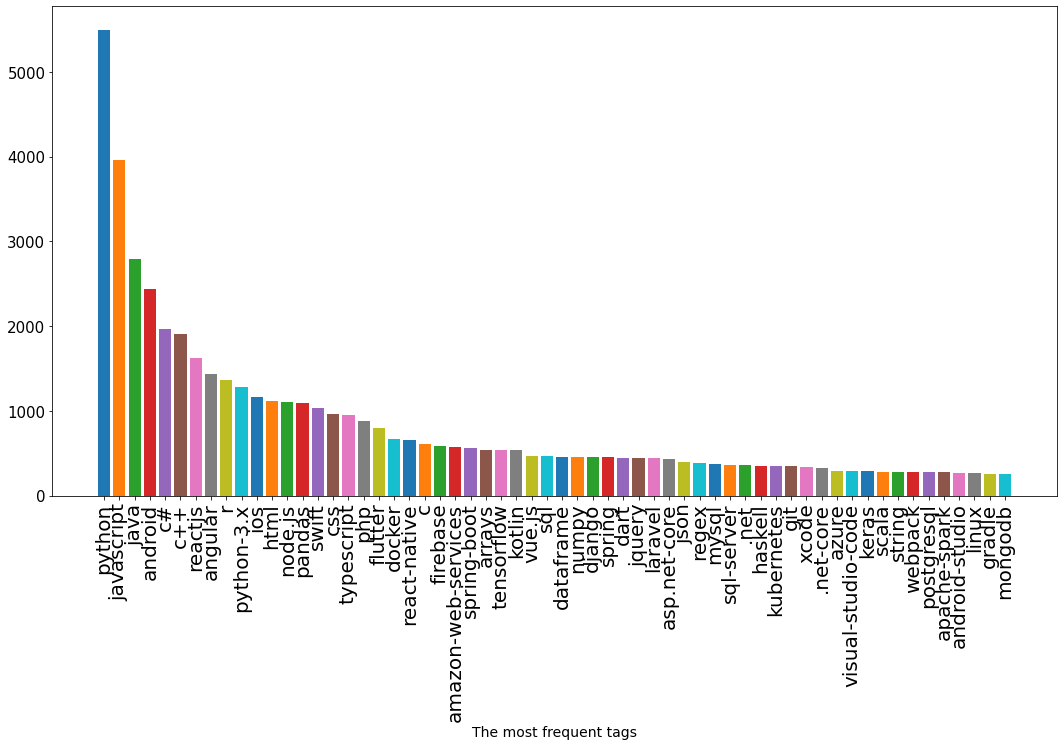

In [59]:
fig, ax = plt.subplots(figsize=(18, 9))


ax.set_xlabel('The most frequent tags', fontsize=14)
ax.bar(x=np.arange(60), 
       height=[x[1] for x in tag_count.most_common(60)],
       tick_label=[x[0] for x in tag_count.most_common(60)],
       color=plt.cm.get_cmap('tab10').colors)

plt.yticks(size=15)
plt.xticks(rotation='vertical', size=20)
plt.show()

In [60]:
def ListeToString(s):
  str1 = " "
  return (str1.join(s))

In [61]:
df_sample['Tag_st'] = df_sample['Tags'].apply(ListeToString)


In [62]:
df_sample.head()

,Title_Body,Title_Body_Tokens,Tags,Tag_st
0,application insights add username telemetry tr...,"[application, insight, add, username, telemetr...","[c#, asp.net, azure-application-insights]",c# asp.net azure-application-insights
1,values neighbor value compering column pandas ...,"[value, neighbor, value, compering, column, pa...","[python, pandas, dataframe]",python pandas dataframe
2,specify secret yml namespace example apiversio...,"[specify, secret, yml, namespace, example, api...","[kubernetes, kubectl]",kubernetes kubectl
3,funset elm fold operation trying solve questio...,"[funset, elm, fold, operation, trying, solve, ...","[elm, fold]",elm fold
4,execution sequence conditions statement c++ co...,"[execution, sequence, condition, statement, co...","[c++, if-statement, multiple-conditions]",c++ if-statement multiple-conditions


In [63]:
reorganization1 = ['Title_Body', 'Tag_st', 'Title_Body_Tokens', 'Tags']
df_sample = df_sample[reorganization1]
df_sample.head()

,Title_Body,Tag_st,Title_Body_Tokens,Tags
0,application insights add username telemetry tr...,c# asp.net azure-application-insights,"[application, insight, add, username, telemetr...","[c#, asp.net, azure-application-insights]"
1,values neighbor value compering column pandas ...,python pandas dataframe,"[value, neighbor, value, compering, column, pa...","[python, pandas, dataframe]"
2,specify secret yml namespace example apiversio...,kubernetes kubectl,"[specify, secret, yml, namespace, example, api...","[kubernetes, kubectl]"
3,funset elm fold operation trying solve questio...,elm fold,"[funset, elm, fold, operation, trying, solve, ...","[elm, fold]"
4,execution sequence conditions statement c++ co...,c++ if-statement multiple-conditions,"[execution, sequence, condition, statement, co...","[c++, if-statement, multiple-conditions]"


In [64]:
tags1 = df_sample['Tag_st']
questions1  = df_sample['Title_Body']

In [65]:
tags1.head()

0    c# asp.net azure-application-insights
1                  python pandas dataframe
2                       kubernetes kubectl
3                                 elm fold
4     c++ if-statement multiple-conditions
Name: Tag_st, dtype: object

In [66]:
questions1.head()

0    application insights add username telemetry tr...
1    values neighbor value compering column pandas ...
2    specify secret yml namespace example apiversio...
3    funset elm fold operation trying solve questio...
4    execution sequence conditions statement c++ co...
Name: Title_Body, dtype: object

## **TF-IDF**

In [67]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [68]:
#X_train, X_test, y_train, y_test = train_test_split(questions1, tags1, test_size=0.2)

In [69]:
vectorizer = TfidfVectorizer(tokenizer = tokenize, stop_words = stop_words, max_features=2000)
X_tfidf = vectorizer.fit_transform(questions1).toarray()
#X_train_tfidf = vectorizer.fit_transform(X_train).toarray() 
#X_test_tfidf = vectorizer.fit_transform(X_test).toarray()
#print('Total words: ', len(vectorizer.vocabulary))

/usr/local/lib/python3.6/dist-packages/sklearn/feature_extraction/text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['doe', 'ha', 'wa'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


In [70]:
print(X_tfidf.shape)

(40000, 2000)


In [71]:
print(vectorizer.get_feature_names())

['aa', 'ab', 'abc', 'able', 'absolute', 'abstract', 'abstractautowirecapablebeanfactory', 'abstractbeanfactory', 'acc', 'accept', 'access', 'accessing', 'according', 'account', 'accuracy', 'achieve', 'action', 'activation', 'active', 'activity', 'activitythread', 'actual', 'actually', 'ad', 'adapter', 'add', 'added', 'addeventlistener', 'adding', 'addition', 'additional', 'address', 'admin', 'advance', 'advice', 'aes', 'age', 'agent', 'aggregate', 'ago', 'airflow', 'ajax', 'alert', 'algorithm', 'alias', 'align', 'allocator', 'allow', 'allowed', 'allows', 'alpha', 'alt', 'alternative', 'amazon', 'amp', 'anaconda', 'analysis', 'analytics', 'anchor', 'android', 'androidx', 'angle', 'angular', 'animated', 'animation', 'annotation', 'anonymous', 'answer', 'anybody', 'anymore', 'apache', 'api', 'apis', 'apk', 'app', 'appbar', 'appcompat', 'appdata', 'appear', 'appears', 'append', 'apple', 'application', 'applied', 'apply', 'appreciate', 'appreciated', 'approach', 'appropriate', 'apps', 'apt'

In [72]:
vectorizer.vocabulary_.items()

dict_items([('application', 82), ('add', 25), ('username', 1888), ('trying', 1841), ('log', 1020), ('user', 1886), ('request', 1484), ('way', 1940), ('public', 1385), ('class', 281), ('private', 1346), ('readonly', 1426), ('base', 158), ('protected', 1373), ('override', 1230), ('void', 1928), ('var', 1906), ('identity', 835), ('set', 1605), ('failed', 649), ('ip', 906), ('connection', 351), ('tostring', 1817), ('null', 1176), ('context', 369), ('startup', 1689), ('c', 217), ('service', 1602), ('lt', 1042), ('gt', 779), ('result', 1501), ('safe', 1535), ('handle', 789), ('closed', 295), ('message', 1090), ('source', 1656), ('runtime', 1531), ('boolean', 191), ('amp', 54), ('success', 1727), ('microsoft', 1096), ('security', 1574), ('web', 1942), ('document', 515), ('project', 1366), ('line', 995), ('aspnetcore', 112), ('initialize', 871), ('tried', 1835), ('code', 300), ('new', 1156), ('work', 1962), ('try', 1840), ('dev', 478), ('environment', 584), ('server', 1600), ('instead', 886), 

### **TF-IDF Weights**

In [73]:
#get word frequencies and create wordcloud
#tfidf_weights = [(word, X_train_tfidf.getcol(idx).sum()) for word, idx in vectorizer.vocabulary_.items()]

In [74]:
#type(tfidf_weights)

In [74]:
#tfidf_weights[0:10]

In [75]:
 #import pickle

#with open("list_tfidf_weights.txt", "wb") as fp:  #Pickling
  #pickle.dump(tfidf_weights , fp)

In [75]:
#with open("list_tfidf_weights.txt", "rb") as fp: # Unpickling
  #list_tfidf_weights = pickle.load(fp)
list_tfidf_weights = pd.read_pickle("/content/drive/My Drive/CentraleSupelec_OCR/P6/list_tfidf_weights.txt")
list_tfidf_weights[0:10]

[('assign', 0.8937445556133665),
 ('default', 0.04800581211245784),
 ('value', 0.43565603819959964),
 ('map', 0.12042849105044214),
 ('type', 0.016633483131467924),
 ('variable', 0.07419114971740814),
 ('class', 0.06362778032935071),
 ('constructor', 0.2664344004623517),
 ('trying', 0.13041756301186977),
 ('create', 0.6767706693721733)]

### **WordCloud**

In [76]:
from wordcloud import WordCloud
w = WordCloud(width=1500,height=1200,mode='RGBA',background_color='white',max_words=2000).fit_words(dict(list_tfidf_weights))

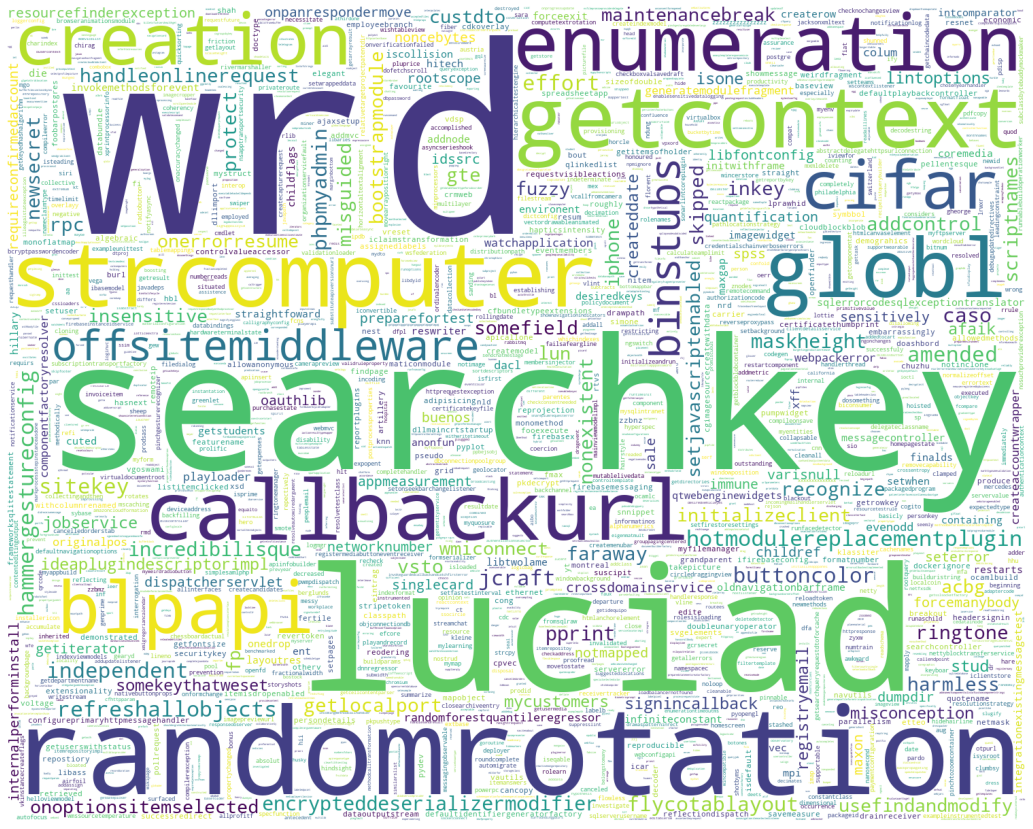

In [77]:
# all below in a single cell
plt.figure(figsize=(20,15))
plt.imshow(w)
plt.axis('off')
plt.savefig('recipes_wordcloud.png')

In [78]:
X_tfidf = pd.DataFrame(X_tfidf)
X_tfidf.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,1960,1961,1962,1963,1964,1965,1966,1967,1968,1969,1970,1971,1972,1973,1974,1975,1976,1977,1978,1979,1980,1981,1982,1983,1984,1985,1986,1987,1988,1989,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999
0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.041541,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.033249,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.085651,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.06058,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.032686,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.475970,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.03201,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.026134,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.037854,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.034061,0.0,0.149459,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.203763,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [79]:
questions_value = vectorizer.vocabulary_
questions_value_df = pd.DataFrame(questions_value.items(), columns=['word', 'value'])
questions_value_df.head()


,word,value
0,application,82
1,add,25
2,username,1888
3,trying,1841
4,log,1020


In [80]:
word_list = questions_value_df['word'].to_list()
X_tfidf.columns = word_list
X_tfidf.head()

,application,add,username,trying,log,user,request,way,public,class,private,readonly,base,protected,override,void,var,identity,set,failed,ip,connection,tostring,null,context,startup,c,service,lt,gt,result,safe,handle,closed,message,source,runtime,boolean,amp,success,...,illuminate,sqlite,anchor,clock,graphql,ii,mouse,patch,filterchainproxy,sale,rb,ruby,constraintlayout,setter,gmail,player,transforms,abstractautowirecapablebeanfactory,bitmap,dbo,fb,purchase,nbsp,gitlab,staging,kube,defaultbuildoperationexecutor,proc,board,myproject,textfield,grep,nonnull,parentrunner,gem,ld,abstractbeanfactory,gulp,pyarrow,keycloak
0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.041541,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.033249,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.085651,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.06058,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.032686,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.475970,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.03201,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.026134,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.037854,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.034061,0.0,0.149459,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.203763,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [81]:
temp = df_sample[['Title_Body']]
X_tfidf = pd.concat([temp, X_tfidf], axis=1 )
X_tfidf.head()

,Title_Body,application,add,username,trying,log,user,request,way,public,class,private,readonly,base,protected,override,void,var,identity,set,failed,ip,connection,tostring,null,context,startup,c,service,lt,gt,result,safe,handle,closed,message,source,runtime,boolean,amp,...,illuminate,sqlite,anchor,clock,graphql,ii,mouse,patch,filterchainproxy,sale,rb,ruby,constraintlayout,setter,gmail,player,transforms,abstractautowirecapablebeanfactory,bitmap,dbo,fb,purchase,nbsp,gitlab,staging,kube,defaultbuildoperationexecutor,proc,board,myproject,textfield,grep,nonnull,parentrunner,gem,ld,abstractbeanfactory,gulp,pyarrow,keycloak
0,application insights add username telemetry tr...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.041541,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.033249,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,values neighbor value compering column pandas ...,0.0,0.085651,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.06058,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.032686,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.475970,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,specify secret yml namespace example apiversio...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.03201,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.026134,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.037854,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.034061,0.0,0.149459,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,funset elm fold operation trying solve questio...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.203763,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,execution sequence conditions statement c++ co...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [84]:
ohe_enc = OneHotCategoricalEncoder(
    top_categories=2000,
    variables=['Tag_st'],
    drop_last=False)
df_tags_num = ohe_enc.fit_transform(df_sample)
df_tags_num = df_tags_num.drop(['Title_Body',	'Title_Body_Tokens',	'Tags'], axis=1)
df_tags_num.head()

,Tag_st_python pandas,Tag_st_python,Tag_st_javascript,Tag_st_r,Tag_st_c++,Tag_st_dart flutter,Tag_st_python pandas dataframe,Tag_st_java,Tag_st_javascript reactjs,Tag_st_html css,Tag_st_python python-3.x,Tag_st_typescript,Tag_st_flutter,Tag_st_angular,Tag_st_android,Tag_st_git,Tag_st_haskell,Tag_st_r ggplot2,Tag_st_react-native,Tag_st_c#,Tag_st_reactjs,Tag_st_r dplyr,Tag_st_rust,Tag_st_python numpy,Tag_st_php laravel,Tag_st_sql sql-server,Tag_st_c,Tag_st_kubernetes,Tag_st_flutter dart,Tag_st_javascript html css,Tag_st_kotlin,Tag_st_python django,Tag_st_python tensorflow,Tag_st_javascript arrays,Tag_st_java java-8 java-stream,Tag_st_javascript jquery,Tag_st_c++ c++11,Tag_st_javascript html,Tag_st_docker,Tag_st_ios swift,...,Tag_st_haskell quickcheck,Tag_st_c++ smart-pointers,Tag_st_javascript html chart.js,Tag_st_c# asp.net-core razor blazor,Tag_st_ios swift uicollectionview uicollectionviewcell,Tag_st_python-3.x matplotlib,Tag_st_javascript r shiny,Tag_st_intellij-idea intellij-plugin,Tag_st_python airflow directed-acyclic-graphs,Tag_st_javascript node.js mongodb express mongoose,Tag_st_ruby-on-rails ruby-on-rails-6 actiontext,Tag_st_c# datatable,Tag_st_git git-stash,Tag_st_cookies,Tag_st_node.js environment-variables,Tag_st_docker mlflow,Tag_st_sql-server excel ssis etl,Tag_st_c++ stl containers,Tag_st_instagram,Tag_st_macos notarize,Tag_st_excel,Tag_st_android firebase firebase-cloud-messaging android-notifications,Tag_st_sonarqube,Tag_st_c# asp.net-core asp.net-core-3.1,Tag_st_javascript functional-programming,Tag_st_java design-patterns builder,Tag_st_ruby-on-rails ruby bundler,Tag_st_nim-lang,Tag_st_python tensorflow neural-network,Tag_st_python r,Tag_st_javascript html video,Tag_st_visual-studio-code vscode-tasks,Tag_st_python image opencv,Tag_st_java android android-fragments,Tag_st_android bluetooth bluetooth-lowenergy,Tag_st_c# entity-framework lambda,Tag_st_python unicode,Tag_st_python pandas pivot-table,Tag_st_google-apps-script google-slides,Tag_st_mongodb pymongo
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
